In [2]:
# This notebook creates some 'gene' statistics, and protein annotation / functional annotation output.
# Also includes the piN piS processing.

### Input files needed:
# - Putativephage_DNARNA_genes.clstr.clst: Cluster file generated by cdhit. (on viral proteins, protein clustering)
# - Putativephage_DNARNA.faa: putative proteins predicted by prodigal (Viral)
# - Bac_JGI_genomeannouncement_combined.fna: Bacterial sequences in fasta format.
# - Putativephage_DNARNA_genes_clustered80.faa: Clustered protein seqs.
# - Phagecluster.emapper.seed_orthologs: Eggnog-mapper annotation output for viral proteins.
# - Phage_clusters.tsv: Interproscan annotation output for viral proteins.
# - FW.gtf : gtf files for the forward orientated contigs (for SNPgenie)
# - RV.gtf : gtf files for the reverse orientated contigs (for SNPgenie)
# - FWres.txt : SNPgenie results for forward orientated contigs
# - RVres.txt : SNPgenie results for reverse orientated contigs.
# - PhagevsBac_clusters.blp : BlastP results for viral proteins vs bacterial proteins. 
# - Bac_JGI_genomeannouncement_combined.faa : Predicted proteins for the bacterial dataset.
# - Bac_JGI_genomeannouncement_combined_ClusteredCDHIT.faa : Clustered proteins for the bacterial dataset.
# - Bac_JGI_genomeannouncement_combined.eggnog.emapper.annotations : eggnog-mapper annotation output for bacterial proteins.
# - Bac_JGI_genomeannouncement_combined_ClusteredCDHIT.faa_GOcols.tsv : interproscan annotation output for bacterial proteins.

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib_venn import venn2
import seaborn as sns
import numpy as np
from Bio import SeqIO
import json
import scipy
sns.set(font='arial')
sns.set_style("white")
sns.set_style("ticks")
%matplotlib inline

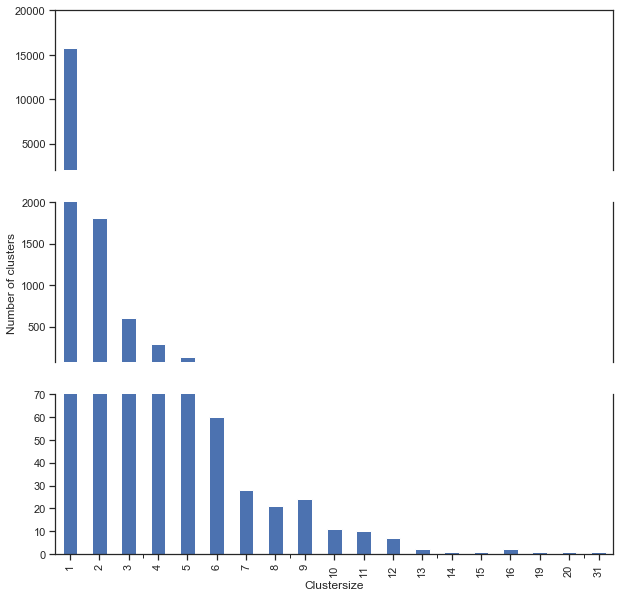

In [4]:
#Get cluster statistics
clusterdic = {}
with open('data/Putativephage_DNARNA_genes.clstr.clstr') as f:
    for line in f:
        if line.strip().startswith('>'):
            clusnum = line.strip().replace('>','')
        else:
            if clusnum in clusterdic:
                clusterdic[clusnum].append(line.strip().split(',')[1].replace(' >',''))
            else:
                clusterdic[clusnum] = [line.strip().split(',')[1].replace(' >','')]
clusterlendic = {}
for i in clusterdic:
    clusterlendic[i] = len(clusterdic[i])
#Create dictionary with the countings:
countdic = {}
for i in clusterlendic:
    if clusterlendic[i] in countdic:
        countdic[clusterlendic[i]] += 1
    else:
        countdic[clusterlendic[i]] = 1

XX = pd.Series(list(countdic.values()),index=list(countdic.keys()))
XX = XX.sort_index(axis = 0) 
g = fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,
                         figsize=(5,6))

g = ax1.spines['bottom'].set_visible(False)
g = ax2.spines['bottom'].set_visible(False)
g = ax2.spines['top'].set_visible(False)
g = ax3.spines['top'].set_visible(False)
g = ax1.tick_params(axis='x',which='both',bottom=False)
g = ax2.tick_params(axis='x',which='both',bottom=False)


g = ax3.set_ylim(0,70)
g = ax2.set_ylim(70,2000)
g = ax1.set_ylim(2000,20000)

g = ax2.set_ylabel("Number of clusters")
g = ax3.set_xlabel("Clustersize")
g = XX.plot(ax=ax1,kind='bar',figsize=(10,10))
g = XX.plot(ax=ax2,kind='bar',figsize=(10,10))
g = XX.plot(ax=ax3,kind='bar',figsize=(10,10))
g.figure.savefig('figures/Clustersizes.png',dpi=300)

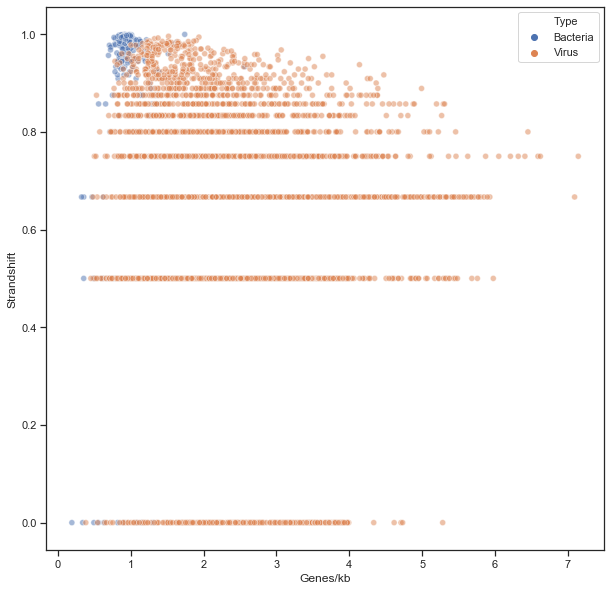

In [5]:
### Gene density
################################### Phages:
phagegenekb2 = {}
phagegenekb = {}
with open('data/Putativephage_DNARNA.faa') as f:
    for line in f:
        if line.startswith('>'):
            nodenam = '_'.join(line.strip().split(' ')[0].replace('>','').split('_')[:-1])
            if nodenam in phagegenekb:
                phagegenekb[nodenam] += 1
            else:
                phagegenekb[nodenam] = 1
for i in phagegenekb:
    if phagegenekb[i] > 1:
        conlen = int(i.split('_')[4])
        densnum = phagegenekb[i]/(conlen/1000)
        phagegenekb2[i] = densnum

#Probability of strand shift
phage_strandshift = {}
with open('data/Putativephage_DNARNA.faa') as f:
    for line in f:
        if line.startswith('>'):
            nodenam = '_'.join(line.strip().split(' ')[0].replace('>','').split('_')[:-1])
            start = int(line.strip().split(' ')[2])
            if nodenam in phage_strandshift:
                phage_strandshift[nodenam].append(start%3)
            else:
                phage_strandshift[nodenam] = [start%3]
phage_strandshift2 = {}
for i in phage_strandshift:
    if len(phage_strandshift[i]) > 1:
        counter = 1
        lastfram = ''
        switchcount = 0
        for j in phage_strandshift[i]:
            if counter == 1:
                lastfram = j
                counter += 1
            else:
                if j != lastfram:
                    switchcount += 1
                    lastfram = j
                    counter += 1
        phage_strandshift2[i] = switchcount / (counter - 1)
phage_strandshift3 = {}
for i in phage_strandshift2:
    conlen = int(str(i).split('_')[4])
    freqnum = phage_strandshift2[i]
    newnum = freqnum/conlen
    phage_strandshift3[i] = newnum
################################### Bacteria:
#Since the read length is not inside fasta header, we need parsing first :(.
bacfas = SeqIO.parse(open('data/Bac_JGI_genomeannouncement_combined.fna'),'fasta')
baclen = {}
for rec in bacfas:
    baclen[rec.id] = len(rec.seq)
#Get the number of genes / KB of contig:
bacgenekb = {}
with open('data/Bac_JGI_genomeannouncement_combined.faa') as f:
    for line in f:
        if line.startswith('>'):
            nodenam = '_'.join(line.strip().split(' ')[0].replace('>','').split('_')[:-1])
            if nodenam in bacgenekb:
                bacgenekb[nodenam] += 1
            else:
                bacgenekb[nodenam] = 1
bacgenekb2 = {}
for i in bacgenekb:
    if bacgenekb[i] > 1:
        conlen = baclen[i]
        densnum = bacgenekb[i]/(conlen/1000)
        bacgenekb2[i] = densnum    
#Probability of strand shift
bac_strandshift = {}
with open('data/Bac_JGI_genomeannouncement_combined.faa') as f:
    for line in f:
        if line.startswith('>'):
            nodenam = '_'.join(line.strip().split(' ')[0].replace('>','').split('_')[:-1])
            start = int(line.strip().split(' ')[2])
            if nodenam in bac_strandshift:
                bac_strandshift[nodenam].append(start%3)
            else:
                bac_strandshift[nodenam] = [start%3]
bac_strandshift2 = {}
for i in bac_strandshift:
    if len(bac_strandshift[i]) > 1:
        counter = 1
        lastfram = ''
        switchcount = 0
        for j in bac_strandshift[i]:
            if counter == 1:
                lastfram = j
                counter += 1
            else:
                if j != lastfram:
                    switchcount += 1
                    lastfram = j
                    counter += 1
        bac_strandshift2[i] = switchcount / (counter-1)
#Create another 1 where the strandshift is normalised by length:
bac_strandshift3 = {}
for i in bac_strandshift2:
    freqnum = bac_strandshift2[i]
    conlen = baclen[i]
    newnum = freqnum/conlen
    bac_strandshift3[i] = newnum
#In dataframe:
bacdf = pd.DataFrame([bacgenekb2, bac_strandshift2, bac_strandshift3])
bacdf = bacdf.T
bacdf.columns = ['Genes/kb','Strandshift','Strandshift_length']
bacdf['Type'] = 'Bacteria'
phagedf = pd.DataFrame([phagegenekb2, phage_strandshift2, phage_strandshift3])
phagedf = phagedf.T
phagedf.columns = ['Genes/kb','Strandshift','Strandshift_length']
phagedf['Type'] = 'Virus'
phagbac = pd.concat([bacdf,phagedf])

#Plot
plt.figure(figsize=(10,10))
g = sns.scatterplot(data=phagbac,x='Genes/kb',y='Strandshift',hue='Type', alpha=0.5)
g.figure.savefig('figures/genesvsstrandshift.png', dpi=300)

1.0727052714754628
2.4950373795252223


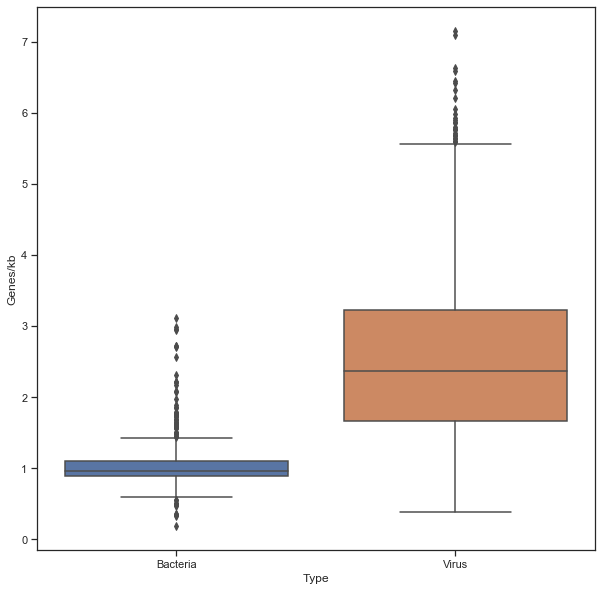

In [17]:
#in boxplots
plt.figure(figsize=(10,10))
g = sns.boxplot(data=phagbac,x='Type',y='Genes/kb')
g.figure.savefig('figures/boxplot_geneskb.png', dpi=300)
scipy.stats.mannwhitneyu(phagbac[phagbac['Type'] == 'Bacteria']['Genes/kb'], phagbac[phagbac['Type'] == 'Virus']['Genes/kb'])

print(phagbac[phagbac['Type'] == 'Bacteria']['Genes/kb'].mean())
print(phagbac[phagbac['Type'] == 'Virus']['Genes/kb'].mean())

0.8418534503016106
0.6292236949643389


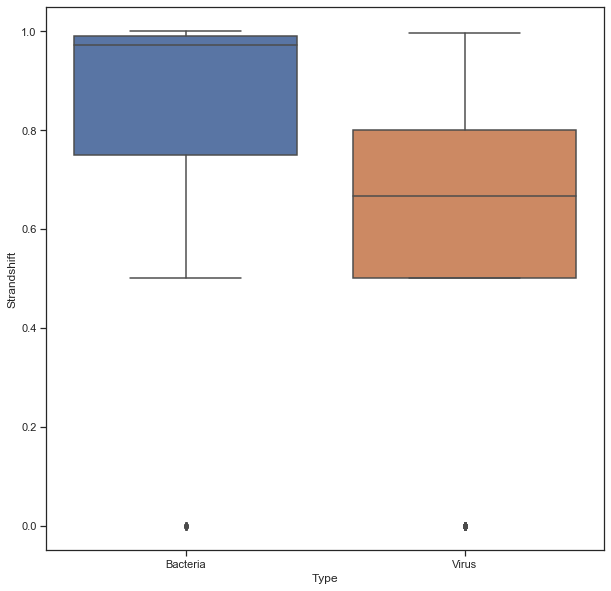

In [7]:
plt.figure(figsize=(10,10))
g = sns.boxplot(data=phagbac,x='Type',y='Strandshift')
g.figure.savefig('figures/boxplot_strandshift.png', dpi=300)
scipy.stats.mannwhitneyu(phagbac[phagbac['Type'] == 'Bacteria']['Strandshift'], phagbac[phagbac['Type'] == 'Virus']['Strandshift'])

print(phagbac[phagbac['Type'] == 'Bacteria']['Strandshift'].mean())
print(phagbac[phagbac['Type'] == 'Virus']['Strandshift'].mean())

MannwhitneyuResult(statistic=216114.0, pvalue=2.540946698392301e-112)

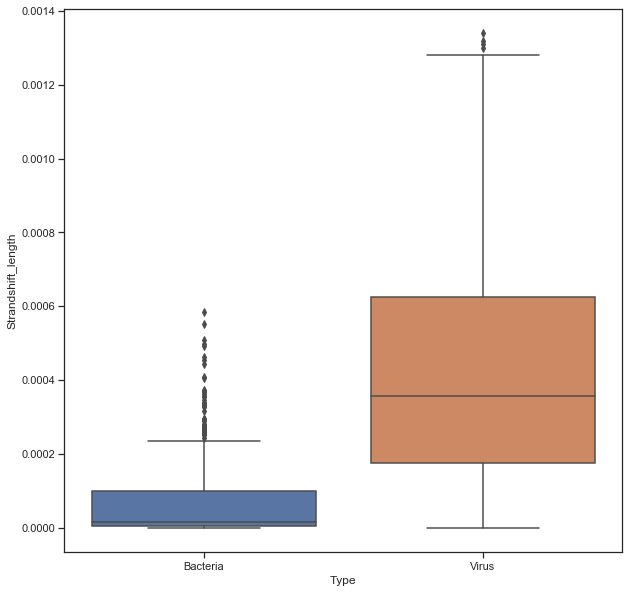

In [8]:
plt.figure(figsize=(10,10))
g = sns.boxplot(data=phagbac,x='Type',y='Strandshift_length')
scipy.stats.mannwhitneyu(phagbac[phagbac['Type'] == 'Bacteria']['Strandshift_length'], phagbac[phagbac['Type'] == 'Virus']['Strandshift_length'])


In [9]:
# Annotated or not.
# Total number of proteins:
prots = []
with open('data/Putativephage_DNARNA.faa') as f:
    for line in f:
        if line.startswith('>'):
            prots.append(line.strip().split(' ')[0].replace('>',''))
print('total prots: ' + str(len(prots)))
#Get the ID's of all the proteinclusters predicted by prodigal:
protclus = []
with open('data/Putativephage_DNARNA_genes_clustered80.faa') as f:
    for line in f:
        if line.startswith('>'):
            protclus.append(line.strip().split(' ')[0].replace('>',''))
print('total clusters: ' +str(len(protclus)))
# Eggnog
eggnogann = {}
with open('data/Phagecluster.emapper.seed_orthologs') as f:
    for line in f:
        if not line.startswith('#'):
            if line.strip().split()[0] not in eggnogann:
                eggnogann[line.strip().split()[0]] = 1
            else:
                print('multiple assignments for eggnog annotation, Check input.')
print('total eggnog ann: ' + str(len(eggnogann)))
#Ipscan
ipscanann = {}
with open('data/Phage_clusters.tsv') as f:
    for line in f:
        prot = line.strip().split()[0].replace('-circular','')
        if prot not in ipscanann:
            ipscanann[prot] = 1
        else:
            ipscanann[prot] += 1
print('total ipscan ann: ' + str(len(ipscanann)))
#Get overlap between ipscan & eggnog:
print('Total eggnog & ipscan: ' + str(len(list(set(list(ipscanann.keys())) & set(list(eggnogann.keys()))))))

total prots: 24420
total clusters: 18747
total eggnog ann: 8559
total ipscan ann: 9254
Total eggnog & ipscan: 5527


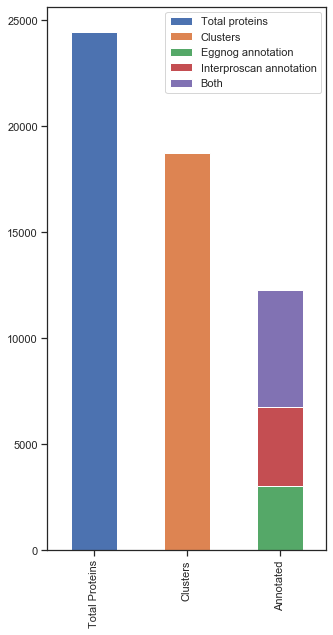

In [10]:
#Create suitable df for stacked df:
lis_tot = [24420,0,0,0,0]
lis_clus = [0,18747,0,0,0]
lis_an = [0,0,3032,3727,5527]
andf = pd.DataFrame([lis_tot,lis_clus,lis_an])
andf.index = ['Total Proteins','Clusters','Annotated']
andf.columns = ['Total proteins','Clusters','Eggnog annotation','Interproscan annotation','Both']
g = andf.plot(kind='bar',stacked=True,figsize=(5,10))
g.figure.savefig('figures/Annotationnumbers.png', dpi=300)

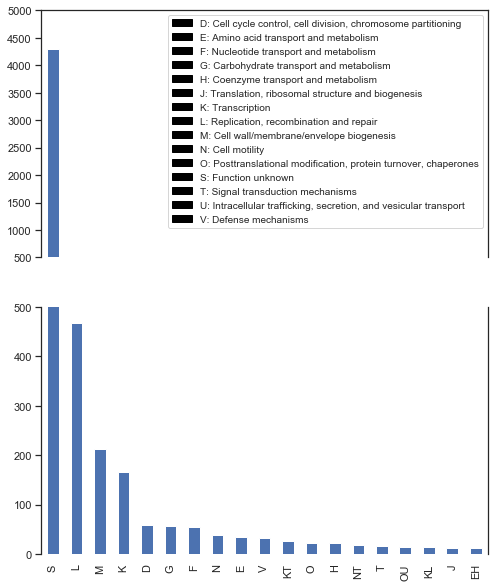

In [11]:
eggnogdf = pd.read_csv('data/Phagecluster.emapper.annotations', sep='\t', comment='#', header=None)
eggnogdf.columns = ['query','seed_ortholog','seed_eval','seed_score','tax','protname','GOs','EC','Kegg_KO','Kegg_path','Kegg_mod','Kegg_reaction','Kegg_rclass','Brite','Kegg_TC','Cazy','BiGG','tax_scope','eggnogOG','bestOG','COG','Freetext']

eggnogdf['COG'].value_counts

## INFORMATION STORAGE AND PROCESSING
# [J] Translation, ribosomal structure and biogenesis 
# [A] RNA processing and modification 
# [K] Transcription 
# [L] Replication, recombination and repair 
# [B] Chromatin structure and dynamics 

## CELLULAR PROCESSES AND SIGNALING
# [D] Cell cycle control, cell division, chromosome partitioning 
# [Y] Nuclear structure 
# [V] Defense mechanisms 
# [T] Signal transduction mechanisms 
# [M] Cell wall/membrane/envelope biogenesis 
# [N] Cell motility 
# [Z] Cytoskeleton 
# [W] Extracellular structures 
# [U] Intracellular trafficking, secretion, and vesicular transport 
# [O] Posttranslational modification, protein turnover, chaperones 

##METABOLISM
# [C] Energy production and conversion 
# [G] Carbohydrate transport and metabolism 
# [E] Amino acid transport and metabolism 
# [F] Nucleotide transport and metabolism 
# [H] Coenzyme transport and metabolism 
# [I] Lipid transport and metabolism 
# [P] Inorganic ion transport and metabolism 
# [Q] Secondary metabolites biosynthesis, transport and catabolism 

## POORLY CHARACTERIZED
# [R] General function prediction only 
# [S] Function unknown
#eggnogdf['COG'].value_counts()[eggnogdf['COG'].value_counts() > 10].plot(kind='bar')

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,
                         figsize=(5,6))
ax1.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.tick_params(axis='x',which='both',bottom=False)

ax2.set_ylim(0,500)
ax1.set_ylim(500,5000)

g = eggnogdf['COG'].value_counts()[eggnogdf['COG'].value_counts() > 10].plot(ax=ax1,kind='bar',figsize=(8,10))
g = eggnogdf['COG'].value_counts()[eggnogdf['COG'].value_counts() > 10].plot(ax=ax2,kind='bar', legend=False,figsize=(8,10))


#Manual legend
D = mpatches.Patch(color='black', label='D: Cell cycle control, cell division, chromosome partitioning')
E = mpatches.Patch(color='black', label='E: Amino acid transport and metabolism')
F = mpatches.Patch(color='black', label='F: Nucleotide transport and metabolism')
G = mpatches.Patch(color='black', label='G: Carbohydrate transport and metabolism')
H = mpatches.Patch(color='black', label='H: Coenzyme transport and metabolism')
J = mpatches.Patch(color='black', label='J: Translation, ribosomal structure and biogenesis')
K = mpatches.Patch(color='black', label='K: Transcription')
L = mpatches.Patch(color='black', label='L: Replication, recombination and repair')
M = mpatches.Patch(color='black', label='M: Cell wall/membrane/envelope biogenesis')
N = mpatches.Patch(color='black', label='N: Cell motility')
O = mpatches.Patch(color='black', label='O: Posttranslational modification, protein turnover, chaperones')
S = mpatches.Patch(color='black', label='S: Function unknown')
T = mpatches.Patch(color='black', label='T: Signal transduction mechanisms')
U = mpatches.Patch(color='black', label='U: Intracellular trafficking, secretion, and vesicular transport')
V = mpatches.Patch(color='black', label='V: Defense mechanisms')



g = plt.legend(handles=[D,E,F,G,H,J,K,L,M,N,O,S,T,U,V],prop={'size': 10 }, loc='upper right', bbox_to_anchor=(1, 2.2))
g.figure.savefig('figures/COGclass.png', dpi=300)

In [12]:
#Interproscan
ipdf = pd.read_csv('data/Phage_clusters.tsv', sep='\t', comment='#', header=None)
ipdf.columns=['query','MD5','length','DB','Acc','desc','start','stop','score','status','date','IP_acc','IP_desc','GOs','Pathway']
ip_accs = []
for i in ipdf['IP_acc']:
    if str(i).startswith('I'):
        if i not in ip_accs:
            ip_accs.append(i)
#Grab all GO terms from df:
IP_go = {}
for i in ipdf['GOs']:
    if str(i).startswith('GO'):
        if '|' in str(i):
            for j in i.split('|'):
                if j not in IP_go:
                    IP_go[j] = 1
                else:
                    IP_go[j] += 1
        else:
            if str(i) not in IP_go:
                IP_go[j] = 1
            else:
                IP_go[j] += 1
#Do the same for the eggnogs:
EGG_go = {}
for i in eggnogdf['GOs']:
    if str(i).startswith('GO'):
        if ',' in str(i):
            for j in i.split(','):
                if j not in EGG_go:
                    EGG_go[j] = 1
                else:
                    EGG_go[j] += 1
        else:
            if str(i) not in EGG_go:
                EGG_go[i] = 1
            else:
                EGG_go[i] += 1
#Grab intersection between 2 lists:
EGG_IP_dic = {}
intersect = list(set(list(EGG_go.keys())) & set(list(IP_go.keys())))
for i in IP_go:
    if i in intersect:
        newnum = EGG_go[i] + IP_go[i]
        EGG_IP_dic[i] = newnum
    else:
        EGG_IP_dic[i] = IP_go[i]
for i in EGG_go:
    if i not in intersect:
        EGG_IP_dic[i] = EGG_go[i]
for i in EGG_IP_dic:
    print(str(i) + ' ' + str(EGG_IP_dic[i]))
#Grab this countdic for revigo

#Settings for revigo:

#Large & Medium
#Some other quantity, where larger is better
#Whole uniprot
#SimRel

1 1
GO:0003677 358
GO:0005524 54
GO:0016787 308
GO:0004797 18
GO:0016491 71
GO:0055114 50
GO:0003796 165
GO:0009253 31
GO:0016998 65
GO:0008745 108
GO:0003824 414
GO:0051536 7
GO:0005737 79
GO:0043365 4
GO:0051539 8
GO:0016020 46
GO:0022857 7
GO:0055085 7
GO:0015667 4
GO:0090124 13
GO:0006306 149
GO:0008170 6
GO:0004553 59
GO:0005576 13
GO:0005975 28
GO:0030246 2
GO:0003697 76
GO:0006260 101
GO:0004170 31
GO:0046080 12
GO:0006508 36
GO:0008233 13
GO:0004803 14
GO:0006313 29
GO:0015074 20
GO:0009405 16
GO:0019867 18
GO:0003676 232
GO:0004518 190
GO:0009007 68
GO:0032775 11
GO:0008168 42
GO:0032259 19
GO:0000150 43
GO:0006310 26
GO:0003678 110
GO:0003887 211
GO:0006261 18
GO:0006231 62
GO:0050660 72
GO:0050797 1
GO:0003899 130
GO:0006351 8
GO:0000166 63
GO:0003896 43
GO:0004386 40
GO:0008270 22
GO:0019076 50
GO:0019835 2
GO:0006355 40
GO:0003909 13
GO:0051103 13
GO:0003910 29
GO:0006281 132
GO:0004842 3
GO:0016567 1
GO:0046872 41
GO:0006139 273
GO:0008408 236
GO:0004568 9
GO:0006032 8
GO

In [13]:
#These 2 lists (ipscan & eggnog) are combined and used for REVIGO input: http://revigo.irb.hr/
#Output treemaps are taken and put in output as R scripts to generate figures.

#To get the relative counts, we take the GO's included in the 3 categories, en sum up the counts from previous DF:
#CELCOM:
molfun = ["GO:0000287","GO:0050897","GO:1901265","GO:0043168","GO:0043167","GO:0043169","GO:0043178","GO:0031419","GO:0031420","GO:0070279","GO:0030955","GO:0046914","GO:0046872","GO:0019842","GO:0050660","GO:0008270","GO:0030170","GO:0003676","GO:0000166","GO:0097159","GO:1901363","GO:0005506","GO:0005509","GO:0036094","GO:0003674","GO:0003700","GO:0001130","GO:0001210","GO:0001199","GO:0003735","GO:0003824","GO:0005198","GO:0005215","GO:0005488","GO:0008408","GO:0016798","GO:0008962","GO:0016791","GO:0016794","GO:0016814","GO:0008979","GO:0016817","GO:0004132","GO:0016810","GO:0004113","GO:0016788","GO:0004197","GO:0044824","GO:0016857","GO:0044823","GO:0016854","GO:0004170","GO:0004176","GO:0047429","GO:0033973","GO:0004252","GO:0033922","GO:0008094","GO:0046555","GO:0046556","GO:0008253","GO:0048256","GO:0004386","GO:0047846","GO:0003796","GO:0003934","GO:0008186","GO:0004427","GO:0008234","GO:0008233","GO:0070001","GO:0003918","GO:0003678","GO:0052689","GO:0016887","GO:0008893","GO:0004523","GO:0016894","GO:0004518","GO:0016997","GO:1990238","GO:0016996","GO:0004553","GO:0004568","GO:0008843","GO:0008829","GO:0009055","GO:0016987","GO:0030234","GO:0031992","GO:0034257","GO:0022803","GO:0015267","GO:0022857","GO:0015343","GO:0015144","GO:0034291","GO:0034290","GO:0098772","GO:0009009","GO:0008907","GO:0004124","GO:0004122","GO:0016835","GO:0016846","GO:0080146","GO:0000704","GO:0003910","GO:0016881","GO:0016879","GO:0016886","GO:0004748","GO:0004146","GO:0015035","GO:0016645","GO:0016725","GO:0016705","GO:0016620","GO:0043365","GO:0016903","GO:0000150","GO:0061783","GO:0019239","GO:0004803","GO:0003887","GO:0016765","GO:0016772","GO:0016757","GO:0009007","GO:0016773","GO:0016776","GO:0016778","GO:0016779","GO:0047507","GO:0019205","GO:0004713","GO:0042083","GO:0004749","GO:0008174","GO:0008168","GO:0004810","GO:0016748","GO:0004799","GO:0016747","GO:0004797","GO:0016746","GO:0016741","GO:0016749","GO:0004842","GO:0004514","GO:0016874","GO:0046812","GO:0016853","GO:0016829","GO:0008144","GO:0003697","GO:0044212","GO:0008135","GO:0043565","GO:0003747","GO:0001067","GO:0003723","GO:0003677","GO:0003684","GO:0003688","GO:0003690","GO:0000217","GO:0042802","GO:0046983","GO:0008134","GO:0051082","GO:0051087","GO:0042803","GO:0030246","GO:0016787","GO:0051539","GO:0005515","GO:0051540","GO:0016491","GO:0048037","GO:0097367","GO:0016740","GO:0000822"]
bioproc = ["GO:0001906","GO:0008150","GO:0008152","GO:0009987","GO:0022610","GO:0034258","GO:0055085","GO:0006810","GO:0040007","GO:0040011","GO:0044419","GO:0044826","GO:0044033","GO:0044035","GO:0044040","GO:0051830","GO:0098003","GO:0039687","GO:0039695","GO:0039678","GO:0019042","GO:0019044","GO:0085027","GO:0019072","GO:0019075","GO:0044278","GO:0046797","GO:0048519","GO:0090066","GO:0048523","GO:0048518","GO:0023051","GO:0032268","GO:0051716","GO:0001959","GO:0051707","GO:0051246","GO:0048583","GO:0010646","GO:0019725","GO:0019222","GO:0050794","GO:0009628","GO:0010608","GO:2000884","GO:0010038","GO:0009607","GO:0009605","GO:0009992","GO:0044093","GO:0065009","GO:0042221","GO:0065008","GO:0010035","GO:0099018","GO:0010944","GO:0030104","GO:0032535","GO:0006109","GO:0010391","GO:0009314","GO:0006080","GO:0009893","GO:0006451","GO:0000160","GO:0006950","GO:0005976","GO:0050896","GO:0051179","GO:0051704","GO:0065007","GO:0071840","GO:0090305","GO:0006304","GO:0006306","GO:0055086","GO:0006310","GO:0006796","GO:0006313","GO:0006270","GO:0006275","GO:0015074","GO:0006261","GO:0006266","GO:0006278","GO:0000272","GO:0006281","GO:0022616","GO:0016311","GO:0016070","GO:0043150","GO:0071897","GO:0090501","GO:0046434","GO:0055114","GO:0006355","GO:0006352","GO:0045493","GO:1901575","GO:1901564","GO:1901137","GO:0006139","GO:1901136","GO:0009117","GO:0019438","GO:0009129","GO:0043603","GO:0009147","GO:0042737","GO:0006231","GO:0006244","GO:0009149","GO:0015949","GO:0046065","GO:0009162","GO:0006259","GO:0006260","GO:0009200","GO:0090304","GO:0009262","GO:0006022","GO:0009253","GO:0018130","GO:0046654","GO:0033567","GO:0006412","GO:0006414","GO:0006396","GO:0044283","GO:0072529","GO:0044281","GO:0006979","GO:0072527","GO:0019692","GO:1901362","GO:0034248","GO:0051103","GO:0034641","GO:0016998","GO:0051672","GO:0000731","GO:0000724","GO:0034654","GO:1902074","GO:0009056","GO:0032259","GO:0006457","GO:0071554","GO:0071704","GO:0006793","GO:0044237","GO:0044238","GO:0044260","GO:0044267","GO:0046483","GO:0006725","GO:0019538","GO:0010467","GO:0006508","GO:0006996","GO:0051259","GO:0051276","GO:0022607","GO:0044085","GO:0043933","GO:0017144","GO:0007154","GO:0006629","GO:0009059","GO:0044249","GO:0043170","GO:0044271","GO:1901576","GO:1901566","GO:1901135","GO:1901360","GO:0005975","GO:0034645","GO:0009058","GO:0006807"]
celcom = ["GO:0005575","GO:0005576","GO:0005623","GO:0005829","GO:0044464","GO:0044445","GO:0071944","GO:0044444","GO:0043228","GO:0043232","GO:0005737","GO:0044424","GO:0043229","GO:0043590","GO:0005622","GO:0005971","GO:0009295","GO:0016020","GO:0019012","GO:0019867","GO:0032991","GO:0033643","GO:0043226","GO:0044215","GO:0044423","GO:0046729","GO:0046798","GO:0039617","GO:0098021","GO:1902494","GO:0043493","GO:0009360","GO:1904949","GO:0017053","GO:1990391","GO:0032300","GO:0098796","GO:1990234","GO:0044776","GO:1990351","GO:0098009","GO:1990204","GO:0032993","GO:1902495","GO:0009289","GO:0009986","GO:0042597","GO:0016021","GO:0044425","GO:0031224","GO:0030312","GO:0044459","GO:0005886","GO:0005887","GO:0005618","GO:0030313","GO:0031975"]

molfuncount = 0
bioproccount = 0
celcomcount = 0

for i in EGG_IP_dic:
    if i in molfun:
        molfuncount += EGG_IP_dic[i]
for i in EGG_IP_dic:
    if i in bioproc:
        bioproccount += EGG_IP_dic[i]
for i in EGG_IP_dic:
    if i in celcom:
        celcomcount += EGG_IP_dic[i]
print('molfun:' +str(molfuncount))
print('bioproc:' +str(bioproccount))
print('celcom:' +str(celcomcount))

molfuncountrel = molfuncount/bioproccount
bioproccountrel = 1
celcomcountrel = celcomcount/bioproccount

#Make numbers relative for illustrator (radius for 300px):
print('molfunrel: ' + str(molfuncountrel*300))
print('bioprocrel: '+ str(bioproccountrel*300))
print('celcomrel: ' + str(celcomcountrel*300))

molfun:5709
bioproc:11133
celcom:2744
molfunrel: 153.839935327405
bioprocrel: 300
celcomrel: 73.94233360280248


In [14]:
#Now look at KO's for pathway reconstr.
#This output goes straight in kegg mapper.
KOdic = eggnogdf['Kegg_KO'].value_counts().to_dict()
KOdic_fix = {}
for i in KOdic:
    if ',' in i:
        namstr = i.split(',')[0]
        KOdic_fix[namstr] = KOdic[i]
    else:
        KOdic_fix[i] = KOdic[i]
counter = 1
for i in KOdic_fix:
    namstr = 'fun'+str(counter)
    print(namstr + '\t' + i)
    counter += 1

fun1	ko:K06909
fun2	ko:K07474
fun3	ko:K09961
fun4	ko:K06919
fun5	ko:K01185
fun6	ko:K07741
fun7	ko:K03111
fun8	ko:K09960
fun9	ko:K00558
fun10	ko:K01160
fun11	ko:K01447
fun12	ko:K00571
fun13	ko:K01356
fun14	ko:K02334
fun15	ko:K07451
fun16	ko:K02314
fun17	ko:K21449
fun18	ko:K07273
fun19	ko:K07455
fun20	ko:K03791
fun21	ko:K01520
fun22	ko:K06904
fun23	ko:K19303
fun24	ko:K02315
fun25	ko:K07497
fun26	ko:K01358
fun27	ko:K01143
fun28	ko:K01449
fun29	ko:K05802
fun30	ko:K14744
fun31	ko:K20847
fun32	ko:K06204
fun33	ko:K02316
fun34	ko:K07729
fun35	ko:K17733
fun36	ko:K15771
fun37	ko:K07316
fun38	ko:K00525
fun39	ko:K03496
fun40	ko:K11060
fun41	ko:K07319
fun42	ko:K03465
fun43	ko:K19505
fun44	ko:K02338
fun45	ko:K06952
fun46	ko:K02335
fun47	ko:K01095
fun48	ko:K00390
fun49	ko:K02395
fun50	ko:K01494
fun51	ko:K07496
fun52	ko:K19789
fun53	ko:K07733
fun54	ko:K03427
fun55	ko:K21471
fun56	ko:K20276
fun57	ko:K22302
fun58	ko:K03406
fun59	ko:K01184
fun60	ko:K03554
fun61	ko:K12790
fun62	ko:K00948
fun63	ko:K04773
f

In [15]:
#Selection:

#Reverse !caution, this needed to be ran in reverse complement, so we have to turn the prots around!
#First run through the FW.gtf, to obtain the correct link between protein and product
fw_gtfdic = {}
with open('data/FW.gtf') as f:
    for line in f:
        if line.strip().split()[0] not in fw_gtfdic:
            fw_gtfdic[line.strip().split()[0]] = [line.strip().split()[9].replace("\"","").replace(";","")]
        else:
            fw_gtfdic[line.strip().split()[0]].append(line.strip().split()[9].replace("\"","").replace(";",""))
#Reverse the lists in the dic:
fw_gtfdic_or = {}
for i in fw_gtfdic:
    fw_gtfdic_or[i] = fw_gtfdic[i][::-1]


RVfixed = []
with open('data/RVres.txt') as f:
    counter = 0
    for line in f:
        if line.strip().split()[0] == 'file':
            RVfixed.append(line.strip().split())
        else:
            counter += 1
            oldprod = int(line.strip().split()[1].split('_')[1])
            oldprod2 = oldprod - 1
            conname = '_'.join(line.strip().split()[0].split('_')[1::])
            print(line.strip())
            newprod = fw_gtfdic_or[conname][oldprod2]
            newlis = [line.strip().split()[0],newprod]
            newlis2 = newlis + line.strip().split()[2::]
            RVfixed.append(newlis2)

BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_1	0	0	0	0	123.666666666667	35.3333333333333	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_10	0	0	0	0	281	88	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_11	0	0	0	0	389.666666666667	108.333333333333	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_12	0	0	0	0	526.500000000001	157.5	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_13	0	0	0	0	2548.16666666667	760.833333333336	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_14	0	0	0	0	363	87	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_15	0	0	0	0	181.666666666667	52.3333333333333	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_2	0	0	0	0	1113.5	317.5	0	0	0	0	*	*	*
BeeP-01-2013_BeeP-11-2013_NODE_67_length_12287_cov_48_102621	1224_3	0	0	0	0	733.16666666

BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_13	0	0	0	0	330.5	95.5	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_14	0	0	0	0	666.333333333333	203.666666666667	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_15	0	0	0	0	433.833333333334	109.166666666667	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_16	0	0	0	0	543	132	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_17	0	0	0	0	4445.66666666664	1242.33333333334	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_18	0	0	0	0	645.166666666667	173.833333333333	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_19	0	0	0	0	1093.33333333333	307.666666666667	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_2	0	0	0	0	209.5	54.5	0	0	0	0	*	*	*
BeeP-02-2013_BeeP-11-2013_NODE_26_length_25964_cov_91_289643	1184_20	0	0	

BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_24	0	0	0	0	352.5	100.5	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_25	0	0	0	0	175.833333333333	43.1666666666667	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_26	0	0	0	0	187	44	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_27	0	0	0	0	356.666666666667	102.333333333333	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_28	0	0	0	0	402.833333333334	110.166666666667	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_29	0	0	0	1	771.999999999999	203	0	0	0	0.00492610837438423	0	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_30	0	0	0	0	403.666666666667	115.333333333333	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_31	0	0	0	0	385.166666666667	106.833333333333	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_532597	916_32	0	0	0	0	411	108	0	0	0	0	*	*	*
BeeP-02-2013_BP50_NODE_5_length_45555_cov_7_

IndexError: list index out of range

In [ ]:
rvres = pd.DataFrame(RVfixed[1:],columns=RVfixed[0])
fwres = pd.read_csv('data/FWres.txt',sep='\t', header=0)
rvres = rvres[rvres['file'] != 'file']
selres = pd.concat([fwres,rvres])
selres['piN'] = selres['piN'].astype(float)
selres['piS'] = selres['piS'].astype(float)
selres['πN/πS'] = selres.apply(lambda x :x['piN']/x['piS'] if x['piS']!=0 else np.nan,axis=1)

selres['πN/πS ratio'] = np.where(selres['πN/πS']>1, '>1', '<=1')

plt.figure(figsize=(10,10))
g = sns.scatterplot(selres['piS'], selres['piN'], alpha=0.4, hue=selres['πN/πS ratio'])
g = plt.ylim(-0.001, 0.015)
g = plt.xlim(-0.001, 0.05)
g = plt.xlabel("piS")
g = plt.ylabel("piN")
g.figure.savefig('figures/piNpiS.png', dpi=300)

In [ ]:
#Grab those proteins that have high piNpiS.
list(selres[selres['πN/πS ratio'] == '>1']['product'])
posprots = []
with open('data/FW.gtf') as f:
    for line in f:
        if str(line.strip().split()[9].replace("\"","").replace(";","")) in (list(selres[selres['πN/πS ratio'] == '>1']['product'])):
            protnam = str(line.strip().split()[0]) + '_' + str(line.strip().split()[9].replace("\"","").replace(";","")).split('_')[1]
            posprots.append(protnam)

In [ ]:
posdf = selres[selres['πN/πS ratio'] == '>1']
fixedprotnam = []
for i in posdf['file']:
    connam = '_'.join(str(i).split('_')[1:])
    protnum = str(list(posdf[posdf['file'] == i]['product'])[0]).split('_')[1]
    fixstr = connam + '_' + protnum
    fixedprotnam.append(fixstr)
posdf['fixedprotnam'] = fixedprotnam
for i in posprots:
    print(list(posdf[posdf['fixedprotnam'] == i]['fixedprotnam']))
    print(list(posdf[posdf['fixedprotnam'] == i]['πN/πS']))

In [ ]:
#Annotation functions of the pos sel proteins
for i in posprots:
    print(list(ipdf[ipdf['query'] == i]['query']))
    print(list(ipdf[ipdf['query'] == i]['IP_desc']))
          

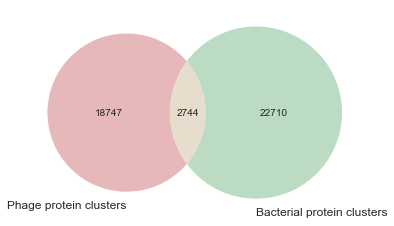

In [18]:
#Grab the proteins that are shared between phages & bacteria:
#Number of clusters in bacteria & in phages:
phagnum = len(clusterdic)
bacnum = 22710
#How many are shared:
phageshit = []
bacshit = []
with open('data/PhagevsBac_clusters.blp') as f:
    for line in f:
        if line.strip().split()[0] not in phageshit:
            phageshit.append(line.strip().split()[0])
        if line.strip().split()[1] not in bacshit:
            bacshit.append(line.strip().split()[1])
g = venn2(subsets = (phagnum,bacnum, 2744), set_labels = ('Phage protein clusters', 'Bacterial protein clusters'))
plt.savefig('figures/Venn_phagevsbac.png', dpi=300)

In [19]:
bacipdf = pd.read_csv('data/Bac_JGI_genomeannouncement_combined_ClusteredCDHIT.faa_GOcols.tsv', sep='\t', comment='#', header=None)
bacipdf.columns=['query','MD5','length','DB','Acc','desc','start','stop','score','status','date','IP_acc','IP_desc','GOs','Pathway']
#GOs based on interproscan:
bachitGO = {}
for i in list(bacipdf[bacipdf['query'].isin(bacshit)]['GOs']):
    if '|' in i:
        for j in i.split('|'):
            if j not in bachitGO:
                bachitGO[j] = 1
            else:
                bachitGO[j] += 1
    else:
        if i not in bachitGO:
            bachitGO[i] = 1
        else:
            bachitGO[i] += 1
#KO based on kegg output:
backeggdf = pd.read_csv('data/Bac_JGI_genomeannouncement_combined.eggnog.emapper.annotations', sep='\t', comment='#', header=None)
backeggdf.columns = ['query','seed_ortholog','seed_eval','seed_score','tax','protname','GOs','EC','Kegg_KO','Kegg_path','Kegg_mod','Kegg_reaction','Kegg_rclass','Brite','Kegg_TC','Cazy','BiGG','tax_scope','eggnogOG','bestOG','COG','Freetext']
bachitKO = {}
for i in list(backeggdf[backeggdf['query'].isin(bacshit)]['Kegg_KO']):
    if str(i).startswith('k'):
        if ',' in i:
            for j in i.split(','):
                if j not in bachitKO:
                    bachitKO[j] =1
                else:
                    bachitKO[j] += 1
        else:
            if i not in bachitKO:
                bachitKO[i] = 1
            else:
                bachitKO[i] += 1
counter = 1
for i in bachitKO:
    print(str(counter) + ' ' + str(i.replace('ko:','')))
    counter += 1
#This output is used in Kegg maper for reconstruction of pathways.

1 K02338
2 K02470
3 K03111
4 K00558
5 K00525
6 K00527
7 K21636
8 K00784
9 K05794
10 K03469
11 K06993
12 K00948
13 K03497
14 K03496
15 K03465
16 K03671
17 K01126
18 K01185
19 K01227
20 K02395
21 K03699
22 K00820
23 K18682
24 K00857
25 K03581
26 K02337
27 K04096
28 K03733
29 K04763
30 K03574
31 K00951
32 K03811
33 K01829
34 K03734
35 K06196
36 K01520
37 K13038
38 K03046
39 K07729
40 K19505
41 K01493
42 K00942
43 K08728
44 K07172
45 K00674
46 K05822
47 K07010
48 K03739
49 K00893
50 K02469
51 K02621
52 K02314
53 K03427
54 K00970
55 K00974
56 K01447
57 K02316
58 K06217
59 K00287
60 K02341
61 K02343
62 K03696
63 K02346
64 K03502
65 K14161
66 K21471
67 K01193
68 K01356
69 K02315
70 K07741
71 K01160
72 K21687
73 K21688
74 K21689
75 K21690
76 K21691
77 K03697
78 K00571
79 K07473
80 K07497
81 K06148
82 K03646
83 K01212
84 K03095
85 K01972
86 K06223
87 K07318
88 K03544
89 K07474
90 K03798
91 K03549
92 K10440
93 K00384
94 K03672
95 K11741
96 K07816
97 K04069
98 K01358
99 K03530
100 K02836
101 K028

In [20]:
# Annotated or not. (for bacteria)
# Total number of proteins:
bacprots = []
with open('data/Bac_JGI_genomeannouncement_combined.faa') as f:
    for line in f:
        if line.startswith('>'):
            bacprots.append(line.strip().split(' ')[0].replace('>',''))
print('total prots: ' + str(len(bacprots)))

#Get the ID's of all the proteinclusters predicted by prodigal:
bacprotclus = []
with open('data/Bac_JGI_genomeannouncement_combined_ClusteredCDHIT.faa') as f:
    for line in f:
        if line.startswith('>'):
            bacprotclus.append(line.strip().split(' ')[0].replace('>',''))
print('total clusters: ' +str(len(bacprotclus)))

# Eggnog
bac_eggnogann = {}
with open('data/Bac_JGI_genomeannouncement_combined.eggnog.emapper.annotations') as f:
    for line in f:
        if not line.startswith('#'):
            if line.strip().split()[0] not in eggnogann:
                bac_eggnogann[line.strip().split()[0]] = 1
            else:
                print('multiple assignments for eggnog annotation, Check input.')
print('total eggnog ann: ' + str(len(bac_eggnogann)))
#Ipscan
bac_ipscanann = {}
with open('data/Bac_JGI_genomeannouncement_combined_ClusteredCDHIT.faa_GOcols.tsv') as f:
    for line in f:
        prot = line.strip().split()[0].replace('-circular','')
        if prot not in bac_ipscanann:
            bac_ipscanann[prot] = 1
        else:
            bac_ipscanann[prot] += 1
print('total ipscan ann: ' + str(len(bac_ipscanann)))
#Get overlap between ipscan & eggnog:
print('Total eggnog & ipscan: ' + str(len(list(set(list(bac_ipscanann.keys())) & set(list(bac_eggnogann.keys()))))))

total prots: 58704
total clusters: 22710
total eggnog ann: 15131
total ipscan ann: 9339
Total eggnog & ipscan: 9244


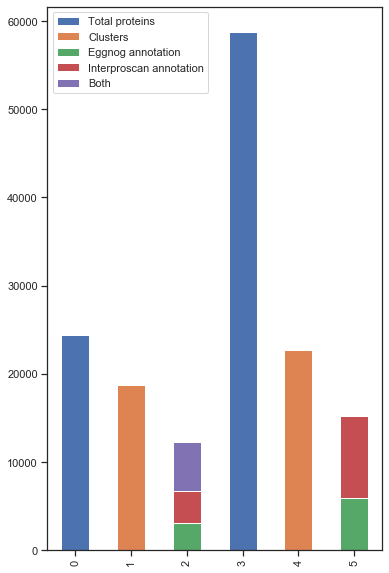

In [21]:
#Create suitable df for stacked df: (bacteria)
lis_tot = [58704,0,0,0,0,'Bacteria']
lis_clus = [0,22710,0,0,0,'Bacteria']
lis_an = [0,0,5887,9339,95,'Bacteria']
phagelis_tot = [24420,0,0,0,0,'Phage']
phagelis_clus = [0,18747,0,0,0,'Phage']
phagelis_an = [0,0,3032,3727,5527,'Phage']


andf = pd.DataFrame([phagelis_tot,phagelis_clus,phagelis_an,lis_tot,lis_clus,lis_an])
andf.columns = ['Total proteins','Clusters','Eggnog annotation','Interproscan annotation','Both','Origin']
g = andf.plot(kind='bar',stacked=True,figsize=(6,10)).legend(loc='upper left')
g.figure.savefig('figures/Annotationnumbers_BacPhage.png', dpi=300)

In [22]:
eggnogdf['COG'].value_counts()

S      4293
L       468
M       212
K       166
D        59
G        56
F        55
N        39
E        34
V        33
KT       26
O        23
H        23
NT       19
T        17
OU       15
KL       14
J        12
EH       11
C         7
NU        7
I         7
Q         6
U         5
A         4
EF        3
P         2
FG        2
UW        2
LU        2
PT        1
MNU       1
KMT       1
IQ        1
DZ        1
CO        1
DM        1
Name: COG, dtype: int64

In [37]:
#See how many of the bacterial clusters fall inside prophage genes:
#Read phaster results
phaster = []
with open('data/Prophages_phaster.csv') as f:
    for line in f:
        if not line.startswith('Contig'):
            bact_id = line.strip().split('_')[1]
            start = int(line.strip().split(';')[1])
            stop  = int(line.strip().split(';')[2])
            phaster.append([bact_id, start,stop])
AMG_prophage = []
for i in bacshit:
    amgID = i.split('_')[1]
    if i.split('_')[2] < i.split('_')[3]:
        start = int(i.split('_')[2])
        stop = int(i.split('_')[3])
    else:
        start = int(i.split('_')[3])
        stop = int(i.split('_')[2])
    for j in phaster:
        if amgID == j[0]:
            if j[1] < start and j[2] > stop:
                AMG_prophage.append(i)
len(AMG_prophage)

95

In [31]:
len(bacshit)

1506